In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.queue.regular_process import service_times, interarrival_times, INITIAL_VALUE
from utils.queue.anomalies import shock_service_time, reduced_interarrival_times,increasing_service_times, deterministic_geometric_arrivals
from utils.simulate_markov import simulate_lindley_process, simulate_lindley_process_with_dynamic_anomaly
from utils.markov_depth import calculate_markov_tukey_depth_for_trajectories_using_long_trajectory, QUEUING_MODEL
from utils.roc_curves import plot_roc_curve

# Section 4 - Queuing model - ROC curves

This notebook contains the code used to obtain the ROC curves for the queuing model in Section 4 of the main text and in S5 of the supplementary material.

In [2]:
# Set up the Seaborn style
sns.set(style="whitegrid")

In [3]:
# Fix the random seed for reproducibility 
random_seed = 7
np.random.seed(random_seed)

In [4]:
# Max Number of steps on each trajectory
n_steps = 200
min_n_steps = 50
# Number of steps of the initial long trajectory.
# Used for the initial kernel estimation.
n_steps_long = n_steps*5
# Number of normal trajectories to simulate
M = 100
# Number of anomalous trajectories to simulate
A = 100

# Size of the shock (10%)
ANOMALY_SHOCK_SIZE = 0.1
# Size of the anomalous part (percent of the total length)
ABNORMAL_PART_LENGTH_PERCENT = 0.2

# Bandwidth parameter for the kernel estimation
inverse_bandwidth = np.power(n_steps_long, 1/5)

In [5]:
# Simulate a long queue process, used to estimate the kernel
random_seed += 1
long_queue_trajectory = simulate_lindley_process(
    n_steps=n_steps_long,
    interarrival_times=interarrival_times,
    service_times=service_times,
    initial_value=INITIAL_VALUE,
    num_processes=1,
    seed=random_seed,
)[0]

In [6]:
# Simulate  queue processes of varying lengths
random_seed +=1
regular_queue_trajectories = simulate_lindley_process(
    n_steps=n_steps,
    interarrival_times=interarrival_times,
    service_times=service_times,
    initial_value=INITIAL_VALUE,
    num_processes=M,
    min_n_step=min_n_steps,
    seed=random_seed,
)

In [7]:
regular_queue_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=regular_queue_trajectories, long_trajectory=long_queue_trajectory, inverse_bandwidth=inverse_bandwidth, marginal_cdf_estimator=QUEUING_MODEL)

## Model 1 (Shock anomalies)

In [8]:
# Simulate anomalous queue process of varying length
random_seed +=1
anomalous_shock_queue_trajectories = simulate_lindley_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    interarrival_times=interarrival_times,
    service_times=service_times,
    anomalous_interarrival_times=interarrival_times,
    anomalous_service_times=shock_service_time,
    initial_value=INITIAL_VALUE, 
    num_processes=A, 
    anomaly_size=ANOMALY_SHOCK_SIZE,
    seed=random_seed,
    min_n_step=min_n_steps,
    restart_after_anomaly=True,
)

In [9]:
anomalous_shock_queue_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_shock_queue_trajectories, long_trajectory=long_queue_trajectory, inverse_bandwidth=inverse_bandwidth, marginal_cdf_estimator=QUEUING_MODEL)

/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kernel_estimation.py:89: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(K * L) / denominator
/Users/carlos/work/Post-Doc/Statistical depth/depth_markov/utils/kerne

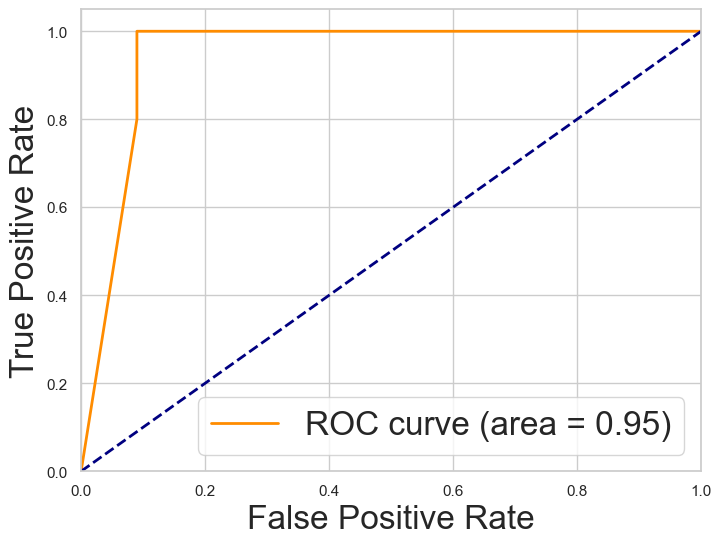

In [10]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_queue_depths, 1-anomalous_shock_queue_depths))

plot_roc_curve(labels=labels, values=depth_values)
plt.show()

## Model 2 (Reduced interarrival times)

In [11]:
# Simulate anomalous process
random_seed +=1
anomalous_reduced_interarrival_queue_trajectories = simulate_lindley_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    interarrival_times=interarrival_times,
    service_times=service_times, 
    anomalous_interarrival_times=reduced_interarrival_times,
    anomalous_service_times=service_times,
    initial_value=INITIAL_VALUE, 
    num_processes=A, 
    anomaly_size=ABNORMAL_PART_LENGTH_PERCENT,
    restart_after_anomaly=True,
    min_n_step=min_n_steps,
    seed=random_seed,
)

In [12]:
anomalous_reduced_interarrival_queue_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_reduced_interarrival_queue_trajectories, long_trajectory=long_queue_trajectory, inverse_bandwidth=inverse_bandwidth, marginal_cdf_estimator=QUEUING_MODEL)

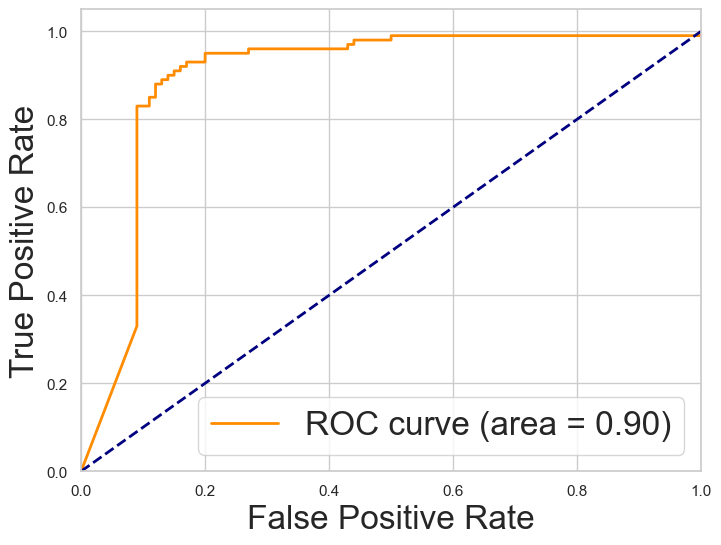

In [13]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_queue_depths, 1-anomalous_reduced_interarrival_queue_depths))

plot_roc_curve(labels=labels, values=depth_values)
plt.show()

## Model 3 (slight increase in service times)

In [14]:
# Simulate anomalous process
random_seed +=1
anomalous_increasing_service_times_queue_trajectories = simulate_lindley_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    interarrival_times=interarrival_times,
    service_times=service_times, 
    anomalous_interarrival_times=interarrival_times,
    anomalous_service_times=increasing_service_times,
    initial_value=INITIAL_VALUE, 
    num_processes=A, 
    anomaly_size=0.3,
    min_n_step=min_n_steps,
    seed=random_seed,
    restart_after_anomaly=True,
)

In [15]:
anomalous_increasing_service_times_queue_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_increasing_service_times_queue_trajectories, long_trajectory=long_queue_trajectory, inverse_bandwidth=inverse_bandwidth, marginal_cdf_estimator=QUEUING_MODEL)

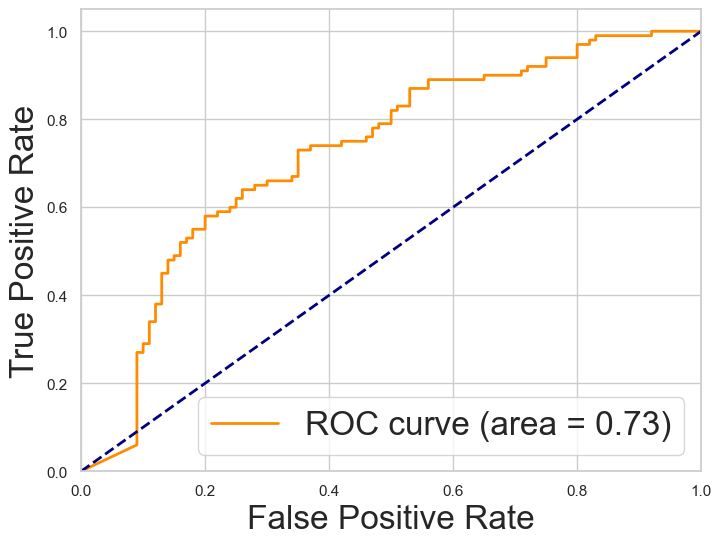

In [16]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_queue_depths, 1-anomalous_increasing_service_times_queue_depths))

plot_roc_curve(labels=labels, values=depth_values)
plt.show()

## Model 4 (Deterministic geometric arrivals)

In [17]:
# Simulate anomalous process
random_seed +=1
anomalous_deterministic_geometric_arrivals_queue_trajectories = simulate_lindley_process_with_dynamic_anomaly(
    n_steps=n_steps, 
    interarrival_times=interarrival_times,
    service_times=service_times, 
    anomalous_interarrival_times=deterministic_geometric_arrivals,
    anomalous_service_times=service_times,
    initial_value=INITIAL_VALUE, 
    num_processes=A, 
    anomaly_size=25,
    min_n_step=min_n_steps,
    seed=random_seed,
)

In [18]:
anomalous_deterministic_geometric_arrivals_queue_depths = calculate_markov_tukey_depth_for_trajectories_using_long_trajectory(trajectories=anomalous_deterministic_geometric_arrivals_queue_trajectories, long_trajectory=long_queue_trajectory, inverse_bandwidth=inverse_bandwidth, marginal_cdf_estimator=QUEUING_MODEL)

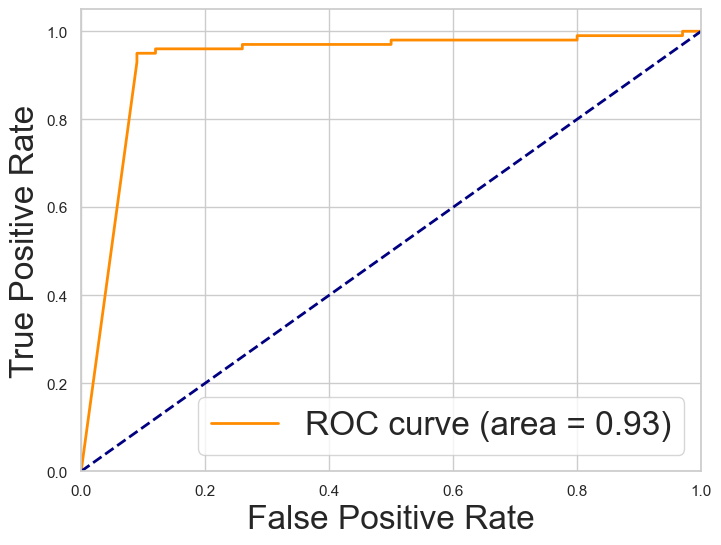

In [19]:
# Because we are labeling regular trajectories as False and anomalous as True,
# and our depth function should be smaller for anomalies, we are using 1-depth 
# for classification.
labels = np.concatenate((np.zeros(M, dtype=bool), np.ones(A, dtype=bool)))
depth_values = np.concatenate((1-regular_queue_depths, 1-anomalous_deterministic_geometric_arrivals_queue_depths))

plot_roc_curve(labels=labels, values=depth_values)
plt.show()